![title](datarobot.jpg)

# DataRobot Python API Starter Activity 
# Part 2 — Interpret Modeling Results

## Pre-requisites


*Before starting this activity (Part 2), be sure to complete Part 1 (including waiting for Autopilot to complete).*
    


## Part 2 Objectives

In Part 2, you will:
- Fetch an already existing project and associated model(s)
- View model metrics
- Get model insights

### Activity Goal (a refresher):

As a reminder, the goal in this activity is to predict the quality rating for a particular wine based on various characteristics of the wine, such as its acidity and alcohol and sugar content.

The wine data comes from the University of California, Irvine Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/wine+quality. 

Citation: *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*

---

## Notebook setup

i.e. steps 1, 2, & 3 from the part 1 notebook

#### Jupyter Notebook Tip

Before you start running any code, we recommend you enable Jupyter interactive shell feature, which allows you to see all of the output a particular Jupyter cell produces rather than just the last output. This will be particularly helpful as you complete your exercises.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Import Libraries

In [2]:
import pandas as pd
import datarobot as dr

#### Connect the application or notebook to DataRobot

You will need to run the same client setup you did in part 1.

In [3]:
# Remove or comment out this line if you are using DataRobot Notebooks
dr.Client(config_path = 'drconfig.yaml')

# Let's start investigating our project and its models

When `wait_for_autopilot()` returns, Autopilot has trained an initial set of models in the project. Because you are working in a separate notebook from the one where you started the project, you need to request a reference to the project created from DataRobot.


## 1. Retrieving a project and its models

There are two key ways to access information once modeling has been completed: via  `project` and  `model` objects. </br>
`project` and `model` objects can be leveraged to dig deeper, access information, and gain insights. </br>

### 1a. Retrieve a project

- We will start by using the DataRobot Client API `Project` to retrieve an existing DataRobot project of our choice.

- To do this, you will need a Project id.

- There are a number of ways to get the id to your project. For example:
    - You can go to the DataRobot application UI, open the project, and extract the project ID from the URL. For example:
        - `app.datarobot.com/projects/`**`60faf10710c1574209c6ddb0`**`/models`
    - You can get a list of all of your projects using `Project.list()` and find the right one by name. Try that now:

In [ ]:
for p in dr.Project.list():
    print (p.id, p.project_name)

Using the ID, you can get the right `Project` object.

In [4]:
projectId = '65774a827fce32b668b7c673' #your-project-id
project = dr.Project.get(projectId)
print(project)

Project(Python wine quality 2023-12-11)


See more about the `Project` class in the docs [here](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/modeling/project.html?highlight=project)

### 1b. Retrieve models

- A DataRobot Client API `Model` object represents a model calculated by DataRobot within a project.

- The `Model` object provides numerous ways to evaluate, interact with and test models.

- Models also have associated IDs, so they can be uniquely identified and handled via the API.

- See more in the docs [here](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/autodoc/api_reference.html#model)

Let's get all the models in the leaderboard of our project that we just fetched:

In [7]:
models = project.get_models()
for m in models:
    print(m.id, m.model_type)

65774c39174d4613acef2eb0 RandomForest Regressor
65774b0758bfa0dcc1b287f5 RandomForest Regressor
65774b0758bfa0dcc1b287f3 Light Gradient Boosted Trees Regressor with Early Stopping
65774b0758bfa0dcc1b287f7 eXtreme Gradient Boosted Trees Regressor
65774b0758bfa0dcc1b287f4 Light Gradient Boosting on ElasticNet Predictions 
65774b0758bfa0dcc1b287f6 RuleFit Regressor
65774b0758bfa0dcc1b287f2 Generalized Additive2 Model
65774b0758bfa0dcc1b287f0 Ridge Regressor
65774b0758bfa0dcc1b287f1 Elastic-Net Regressor (mixing alpha=0.5 / Least-Squares Loss)


### 1c. Retrieve the recommended model

DataRobot automatically recommends the most accurate model and prepares the model for deployment.</br>
</br>
See more about the model recommendation process in DataRobot in the docs [here](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/model-rec-process.html)</br>
See more about DataRobot's "prepare for deployment" in the docs [here](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/model-rec-process.html#prepare-a-model-for-deployment)

In [8]:
# We simply need the project id to retrieve the recommended model with the following function

recommendedModel = dr.ModelRecommendation.get(project.id).get_model()
print (recommendedModel.id,recommendedModel.model_type)

65774c39174d4613acef2eb0 RandomForest Regressor


## 2. View metrics for models in the leaderboard

If you would like to investigate the various models in the leaderboard and choose your own, rather than simply continuing with the recommended model, the `.metrics()` function would be a good place to start.

We collected all the model objects from the project into `models`. Let's pick a model at random and take a look at the RMSE across all cross-validation folds using the `.metrics()` function

In [ ]:
# Choose one model from the list of models we gathered
model = models[1]

# Print the RMSE of that model from across all CV folds
model.metrics['RMSE']['crossValidation']

#### Now, let's do this for all models in the leaderboard

First, we make sure to run all cross-validation metrics calculations for all the models in the leaderboard, if they have not been computed already </br>

In [9]:
metric_type = 'RMSE'
for m in models:

    if m.metrics[metric_type]["crossValidation"] == None:
        try: 
            dr.Model.cross_validate(m)
            print(f'Computing CV Scores for model {m.model_type} in Project {project.project_name}')
            print(' ')
        except dr.errors.ClientError:
            pass
            print(f'All CV Scores have been submitted for scoring for project {project.project_name}')
            print(' ')

# update the model results
models = project.get_models()

Next, let's loop through all the models and use some more model attributes to gather information, including cross validation RMSE

In [10]:
cv_rmse_scores = pd.DataFrame()

for m in models:
    
    df = pd.DataFrame([{'model_type': m.model_type,
                    'model_id': m.id,
                    'sample_pct': m.sample_pct,
                    'featurelist': m.featurelist_name,
                    'cross_val_RMSE': m.metrics['RMSE']['crossValidation']}])
    cv_rmse_scores = pd.concat([cv_rmse_scores,df], axis = 0, ignore_index=True)
    
cv_rmse_scores

,model_type,model_id,sample_pct,featurelist,cross_val_RMSE
0,RandomForest Regressor,65774c39174d4613acef2eb0,100.0000,Informative Features,0.614260
1,RandomForest Regressor,65774b0758bfa0dcc1b287f5,63.9836,Informative Features,0.629826
2,Light Gradient Boosted Trees Regressor with Ea...,65774b0758bfa0dcc1b287f3,63.9836,Informative Features,0.647134
3,eXtreme Gradient Boosted Trees Regressor,65774b0758bfa0dcc1b287f7,63.9836,Informative Features,0.646996
4,Light Gradient Boosting on ElasticNet Predicti...,65774b0758bfa0dcc1b287f4,63.9836,Informative Features,0.648010
5,RuleFit Regressor,65774b0758bfa0dcc1b287f6,63.9836,Informative Features,0.690190
6,Generalized Additive2 Model,65774b0758bfa0dcc1b287f2,63.9836,Informative Features,0.707420
7,Ridge Regressor,65774b0758bfa0dcc1b287f0,63.9836,Informative Features,0.733042
8,Elastic-Net Regressor (mixing alpha=0.5 / Leas...,65774b0758bfa0dcc1b287f1,63.9836,Informative Features,0.749406


## 3. View model insights

### 3a. Feature Impact

Let's see which of the modeling inputs contributed the most towards wine quality. You can do this for any model in the leaderboard. As an example, we will use the `recommendedModel`

DataRobot automatically calculates normalized impact scores for each input variable. We will use the `recommendedModel`to get impact scores for the model, and then plot them.

See more about Feature Impact, and how DataRobot calculates it in the docs [here](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html#feature-impact_)

In [11]:
max_num_features = 15
time_to_wait_for_impact = 4 * 60  # seconds

try:
    feature_impacts = recommendedModel.get_feature_impact()  # if they've already been computed
except dr.errors.ClientError as e:
    assert e.status_code == 404  # the feature impact score haven't been computed yet
    impact_job = recommendedModel.request_feature_impact()
    feature_impacts = impact_job.get_result_when_complete(time_to_wait_for_impact)

feature_impacts.sort(key=lambda x: x['impactNormalized'], reverse=True)
FeatureImpactDF = pd.DataFrame([{'Impact Normalized': f["impactNormalized"],
                                 'Feature Name': f["featureName"]}
                                for f in feature_impacts[:max_num_features]])

In [12]:
FeatureImpactDF

,Impact Normalized,Feature Name
0,1.000000,alcohol
1,0.609860,volatile acidity
2,0.475324,density
3,0.442270,free sulfur dioxide
4,0.410862,chlorides
5,0.354700,residual sugar
6,0.327096,pH
7,0.325254,total sulfur dioxide
8,0.316519,citric acid
9,0.245333,fixed acidity


<Axes: xlabel='Impact Normalized', ylabel='Feature Name'>

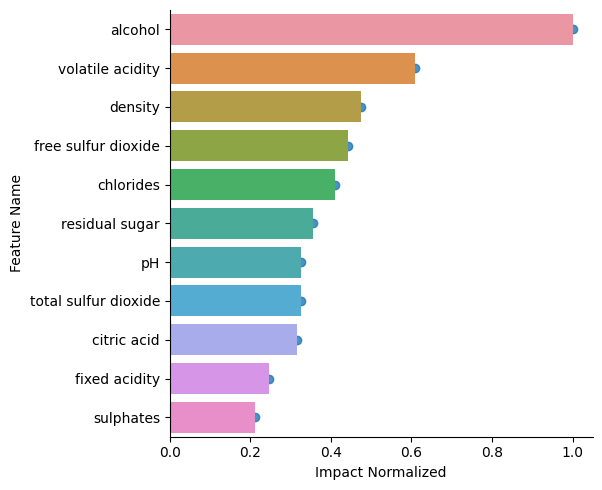

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

#Graph Feature Impact based on the normalized impact
FeatureImpactDF["X axis"] = FeatureImpactDF.index
g = sns.lmplot(x="Impact Normalized", y="X axis", data=FeatureImpactDF, fit_reg=False)
sns.barplot(y=FeatureImpactDF["Feature Name"], x=FeatureImpactDF["Impact Normalized"])

### 3b. Feature Effects

Suppose we want to understand how `density` affects the quality of wine. Density is the 3rd most impactful feature, based on the chart above, so it would be interesting to undertand its role in quality further. For example, does higher density lead to lower quality wine?

We can leverage the Feature Effects that DataRobot calculates, to understand how individual features vary with respect to the target (in this case, wine quality). 

Read more about how DataRobot calculates Feature Effects [here](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-effects.html#feature-effects)

We can once more leverage the `model` object to calculate feature effects

In [15]:
# Note the options for "source" are: training, validation, or holdout
feature_effects = model.get_or_request_feature_effect(source='validation')

`density` is the 3rd more impactful feature. So, we can isolate it using the appropriate indexing, since Feature effects are calculated for each variable, in order of their feature impact

In [16]:
fe_density = feature_effects.feature_effects[2]

The Feature Effects insight for a variable is communicated in terms of `partial dependence`, which illustrates how a change in a feature's value, while keeping all other features as they were, impacts a model's predictions. </br>
Let's plot what that looks like for `density`

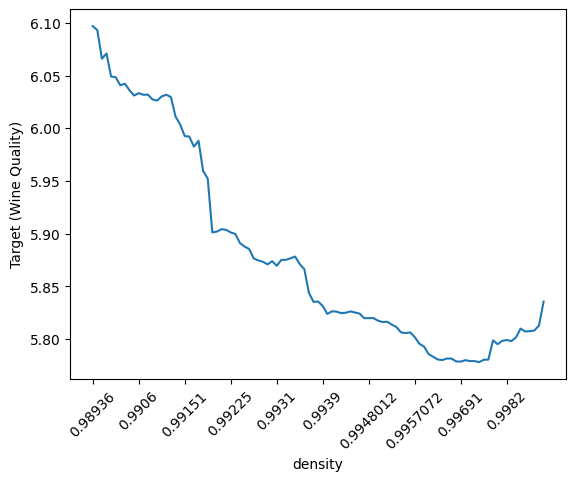

In [19]:
fe_density_df = pd.DataFrame(fe_density['partial_dependence']['data'])

sns.lineplot(x = "label", y = "dependence", data=fe_density_df)
plt.xticks(fe_density_df['label'][::10], rotation = 45) 
plt.xlabel("density")
plt.ylabel("Target (Wine Quality)");

So it appears that higher density does in fact lead to predictions of lower wine quality.